# Chapter 17 
# Representation Learning with Autoencoders and Generative Adversarial Networks (GANs)

Autoencoders are neural networks that learn to copy their inputs. While this may sound trivial, the inputs are generally put under various constraints to make the task difficult, such as adding noise to the inputs or limiting size of the *latent representations*. 

What are *latent representations*? They are precisely what the autoencoder aims to learn. They are dense representations of the input, learned without supervision. They typically have lower dimensionality than the inputs, so this also makes autoencoders useful for dimensionality reduction.

Geberative adversarial networks are composed of two neural nets: a *generator* that is trying to generate some data that looks like the training data (e.g. human faces) and a *discriminator*, which tries to tell which of the images are real data and which were artificially generated by the generator. During trainig, these two models are competing agains each other. GANs are considered on of the most important ideas in ML in recent years.

We'll start by looking at autoencoders

# Efficient Data Representations

Autoencoders are composed of two parts:
- *Encoder (recognition network)* whose job is to convert the inputs to a latent representation
- *Decoder (generative network)* whose job is to convert the internal representation to the outputs

Their architecture are similar to that of MLPs, except that the number of outputs is equal to the number of inputs. Outputs are called *reconstructions* since the autoencoder tries to recostruct the inputs from the latent representation. The cost function will contain a *reconstruction loss* that penalizes the model for generating poor reconstructions (i.e. outputs that do not look like the inputs).

The example in the book (page 570) shows a simple autoencoder with 3 inputs, an encoder with 2 neurons and a decoder with 3 output neurons. The internal representation of the encoder has 2 dimensions instead of 3, and we say the autoencoder is *undercomplete*. Such an autoencoder can't trivially copy the inputs to its codings (internal represenation), but its goal is to output a copy of the inputs. Because of the constraints, the autoencoder is forced to learn the most important features of the inputs data.

## PCA with an Undercomplete Linear Autoencoder

Let's dive in by creating an undercomplete autoencoder. The designed model will only use linear activations and have MSE as its cost function. The result will be an autoencoder that performs PCA

In [1]:
import tensorflow as tf
from tensorflow import keras

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer="SGD")

Generate some random 3D data

In [2]:
import numpy as np
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

And fit. Note the X_train is used as both the input and the output as we're trying to re-construct the inputs.

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=20)
codings = autoencoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 1s 4ms/step - loss: 0.4757
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.4551
Epoch 3/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4281
Epoch 4/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4338
Epoch 5/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4188
Epoch 6/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4087
Epoch 7/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4087
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4009
Epoch 9/20
2/2 [==============================] - 0s 3ms/step - loss: 0.3882
Epoch 10/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4012
Epoch 11/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3797
Epoch 12/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3982
Epoch 13/20
2/2 [==============================] - 0s 4ms/step - loss: 0.

If we plot the first two dimensions of the codings, we will se a 2D projection of the data as a result, just like PCA

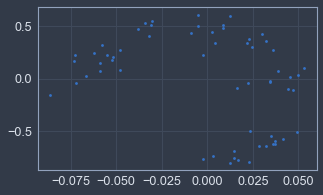

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import jupyterthemes as jt
jt.jtplot.style()

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(codings[:, 0], codings[:, 1], '.')
plt.show()

## Stacked Autoencoders

Just like other Neural Nets, we can add more hidden layers to our autoencoder. Such autoencoders are called *stacked autoencoders* and their architecture resembles a sandwich, in that the layers in the encoder (except the last one) are repeated in the decoder but in reverse order. (picture page 572)

Let's use fashion MNIST to build a stacked autoencoder

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [7]:
def rounding_accuracy(y_true, y_pred):
    """Rounds both target and output to 0,1 and calculates the accuracy"""
    round_true = tf.math.round(y_true)
    round_preds = tf.math.round(y_pred)
    return tf.metrics.binary_accuracy(round_true, round_preds)

In [8]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"), # central layer
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5),
                   metrics=[rounding_accuracy])

history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.3800 - rounding_accuracy: 0.8512 - val_loss: 0.3162 - val_rounding_accuracy: 0.9100
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3089 - rounding_accuracy: 0.9125 - val_loss: 0.3049 - val_rounding_accuracy: 0.9181
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3006 - rounding_accuracy: 0.9200 - val_loss: 0.2971 - val_rounding_accuracy: 0.9243
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2953 - rounding_accuracy: 0.9247 - val_loss: 0.2942 - val_rounding_accuracy: 0.9275
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2924 - rounding_accuracy: 0.9268 - val_loss: 0.2921 - val_rounding_accuracy: 0.9283
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2915 - rounding_accuracy: 0.9279 - val_loss: 0.2919 - val_rounding_accuracy: 0.9308
Epoch 7/10
1719/1719 [======

Note:
- The decoder uses sigmoid activation for its outputs as we're outputing 0 or 1 for each pixel. So we're treating this as a classification problem and use binary_crossentropy as the loss function. Framing the problem this way, rather than as a regression problem, speeds up convergence
- Since we are treating the outputs as probabilities that the pixel should be black, we define a custom accuracy function that rounds the targets and outputs to 0/1 

### Visualizing the reconstructions

Lets' plot the reconstructions and see how the model did

In [6]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [9]:
show_reconstructions(stacked_ae)

NameError: name 'plt' is not defined

Reconstructions are recognizable but a bit lossy. To improve them, we can deepen the architecture, train for longer or make the codings larger. But if we make the network too powerful, it will manage to reconstruct the images perfectly without learning any useful patterns.

### Visualizing the Fashio MNIST dataset

We can now use the autoencoder to reduce dimensionality of fashion MNIST. If we do that, we'll see that it doesn't perform as other algorithms (chapter 8). The advantage they have, is that they can handle large amounts of data with many instances and features, so one viable strategy is to use the autoencoder to reduce dimensionality to a reasonable level, then use another algorithm.

Let's do this with T-SNE

In [10]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid) # Encoder reduces dimension to 30
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

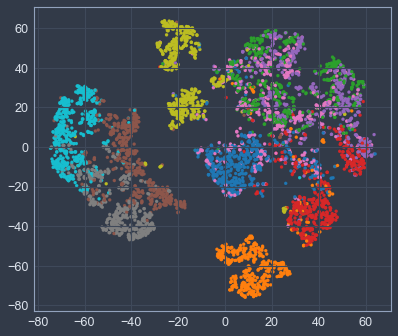

In [11]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

### Unsupervised pre-training using stacked autoencoders

In chapter 11 we pointed out that if we have a complex supervised task, but do not have a lot of labeled training data, we can find a neural net that was pretrained in a similar task and re-use its lower layers. This makes it possible to create a high performing model without vasts amount of labelled data as the NN won't have to learn all the low level features

In a similar fashion, if we have a large dataset that is mostly unlabelled, we can first train a stacked autoencoder using all the data, then re-use the lower layers to create a NN for our actual task and train it using the labelled data. See fig 17-6 on page 576

One thing to note: If we don't have much labelled training data, we may want to freeze the pre-trained layers (at least the lower ones).

We'll explore implementing this architecture in the exercises for the chapter. 

### Tying Weights

When the Autoencoder is symmetrical, we can halve the number of weights to fasten training and reduce the risk of overfitting. To do this, we *tie* the weights if the decoder layers to the weights of the encoder layer.

More specifically, if our autoencoder has *N* layers (not counting input) and $\textbf{W}_L$ represents the weights of the *L*<sup>th</sup> layer, then the decoder layer weights can be defined as:
$$ \textbf{W}_{N-L+1} = \textbf{W}_{L}^{\intercal} $$
with $L = 1, 2, ..., N/2$.

We implement this with a custom class

In [12]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    
    def build(self, batch_input_shape):
        self.biases = self.add_weight(
            name="bias", initializer="zeros",shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
    
    def call(self, inputs):
        z = tf.matmul(inputs, 
                      self.dense.weights[0], # weights from another layer
                      transpose_b=True) # Transposes the second argument
        return self.activation(z + self.biases)

Let's build a new stacked_encoder

In [13]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5),
                metrics=[rounding_accuracy])
tied_ae.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 30)                81530     
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28)            82414     
Total params: 82,414
Trainable params: 82,414
Non-trainable params: 0
_________________________________________________________________


In [14]:
stacked_ae.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 30)                81530     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3720 - rounding_accuracy: 0.8574 - val_loss: 0.3091 - val_rounding_accuracy: 0.9161
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2994 - rounding_accuracy: 0.9203 - val_loss: 0.2943 - val_rounding_accuracy: 0.9281
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2929 - rounding_accuracy: 0.9270 - val_loss: 0.2918 - val_rounding_accuracy: 0.9315
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2892 - rounding_accuracy: 0.9300 - val_loss: 0.2894 - val_rounding_accuracy: 0.9298
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2868 - rounding_accuracy: 0.9326 - val_loss: 0.2867 - val_rounding_accuracy: 0.9352
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2854 - rounding_accuracy: 0.9340 - val_loss: 0.2853 - val_rounding_accuracy: 0.9353
Epoch 7/10
1719/1719 [======

Slightly better performance with half the number of parameters!

### Training one Autoencoder at a time

So far we have trained the autoencoder in one go, however it is also possible to dissect the model into smaller autoencoder and train each individually. This isn't used as much nowadays, but it used to be the only way to train Neural networks back in 2006. The approach is called *Greedy layerwise training*.

See page 578 for a description and the [notebook](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb) for an implementation

## Convolutional Autoencoders

Even with this new architecture, when dealing with images Dense layers will only get you so far. Using a Convolutional Autoencoder will work much better.

The Encoder will be a regular CNN composed of convolutional and pooling layers. Its job is to reduce the spatial dimensionality of the inputs (height, width) while increasing depth (i.e. number of feature maps). 

The Decoder does the opposite, upscaling the image and reducing its depth back to the original dimensions. For this, we can use Transpose Convolutional layers.

Transpose convolutional (or deconvolutional) layers undo the effects of a normal convolution

In [16]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2,
                                 padding="valid", activation="selu", input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2,
                                 padding="same", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5),
                metrics=[rounding_accuracy])

history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2814 - rounding_accuracy: 0.9372 - val_loss: 0.2820 - val_rounding_accuracy: 0.9391
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2810 - rounding_accuracy: 0.9375 - val_loss: 0.2844 - val_rounding_accuracy: 0.9364
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2806 - rounding_accuracy: 0.9380 - val_loss: 0.2828 - val_rounding_accuracy: 0.9366
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2804 - rounding_accuracy: 0.9382 - val_loss: 0.2811 - val_rounding_accuracy: 0.9392
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2801 - rounding_accuracy: 0.9383 - val_loss: 0.2863 - val_rounding_accuracy: 0.9359
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2799 - rounding_accuracy: 0.9385 - val_loss: 0.2809 - val_rounding_accuracy: 0.9396
Epoch 7/10
1719/1719 [======

### Recurrent Autoencoders

When dealing with time-series data, we can use recurrent layers in our autoencoders. The approach is similar, the encoder will be a sequence-to-vector RNN converting the sequence to a single vector. The decoder does the reverse.

We can define a recurrent AE conveniently so that it can process sequences of any length with 28 dimensions per time step, i.e. it can process Fashion MNIST images by treating each image as a sequence of rows: at each time step the RNN processes a single row of 28 pixels.

In [21]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5),
                     metrics=[rounding_accuracy])

with tf.device('/CPU:0'):
    recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_train, X_train))

Epoch 1/10
1719/1719 [==============================] - 71s 39ms/step - loss: 0.4260 - rounding_accuracy: 0.8177 - val_loss: 0.3321 - val_rounding_accuracy: 0.8907
Epoch 2/10
1719/1719 [==============================] - 66s 38ms/step - loss: 0.3246 - rounding_accuracy: 0.8970 - val_loss: 0.3261 - val_rounding_accuracy: 0.8982
Epoch 3/10
1719/1719 [==============================] - 66s 39ms/step - loss: 0.3122 - rounding_accuracy: 0.9069 - val_loss: 0.3089 - val_rounding_accuracy: 0.9109
Epoch 4/10
1719/1719 [==============================] - 67s 39ms/step - loss: 0.3047 - rounding_accuracy: 0.9131 - val_loss: 0.3161 - val_rounding_accuracy: 0.9055
Epoch 5/10
1719/1719 [==============================] - 67s 39ms/step - loss: 0.3009 - rounding_accuracy: 0.9167 - val_loss: 0.2981 - val_rounding_accuracy: 0.9198
Epoch 6/10
1719/1719 [==============================] - 66s 38ms/step - loss: 0.2977 - rounding_accuracy: 0.9198 - val_loss: 0.2933 - val_rounding_accuracy: 0.9233
Epoch 7/10
1719/

So far we looked at various types of autoencoders (basic, stacked, convolutional, recurrent) as well as some way to train them (single shot, layer by layer) for a couple of applications (data viz and unsupervised pretraining).

We'll now look at other constraints that we can appliy with autoencoders.

## Denoising Autoencoders

Aonther way we can force the autoencoder to learn useful features is to train is to add noise to its inputs and training it to recover the noise-free inputs. 

The noice can be pure Gaussian noise or it can be randomly switched-off inputs (just like dropout). Below an implementation with GaussianNoise

In [33]:
gn_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(stddev=0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
gn_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
gn_ae = keras.models.Sequential([gn_encoder, gn_decoder])
gn_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5),
               metrics=[rounding_accuracy])

gn_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3879 - rounding_accuracy: 0.8439 - val_loss: 0.3150 - val_rounding_accuracy: 0.9073
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3123 - rounding_accuracy: 0.9092 - val_loss: 0.3070 - val_rounding_accuracy: 0.9116
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3049 - rounding_accuracy: 0.9154 - val_loss: 0.3001 - val_rounding_accuracy: 0.9208
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3005 - rounding_accuracy: 0.9196 - val_loss: 0.2988 - val_rounding_accuracy: 0.9213
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2973 - rounding_accuracy: 0.9225 - val_loss: 0.2941 - val_rounding_accuracy: 0.9272
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2964 - rounding_accuracy: 0.9238 - val_loss: 0.2933 - val_rounding_accuracy: 0.9284
Epoch 7/10
1719/1719 [======

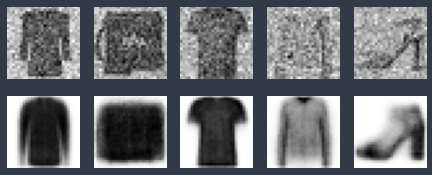

In [32]:
gaussian_noise = keras.layers.GaussianNoise(stddev=.2)
show_reconstructions(gn_ae, images=gaussian_noise(X_valid[:5], training=True))

The image above shows some noisy input against the re-constructed outputs. Autoencoders can be used for removing noise from images (wonder if it can be used for other sorts of data as well ?)

## Sparse Autoencoders

By now, you should understand that at the core of autoencoders is the latent representation generated by the encoder, so if we can make the autoencoder learn only the important features and use them in the latent representation we'll have a good model.

Another constraint we can add to ensure good representations is *sparsity*: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. For example, only 5% of the neurons in the coding layer may be significantly active, which in turn forces the autoencoder to represent each input as a small number of activations and so each neuron in the coding layer will represent a useful feature. (e.g. if you could only speak a few words per month, you'd make sure they were worth listening to)

One way to achieve this is to use a sigmoid activation in the coding layer (constraining values to [0, 1]), a large coding layer and some $l_1$ regularization to the coding layer's output. The decoder will remain the same

In [38]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"), # coding layer
    keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5),
               metrics=[rounding_accuracy])

sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4744 - rounding_accuracy: 0.7857 - val_loss: 0.3730 - val_rounding_accuracy: 0.8645
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3639 - rounding_accuracy: 0.8739 - val_loss: 0.3509 - val_rounding_accuracy: 0.8806
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3453 - rounding_accuracy: 0.8867 - val_loss: 0.3445 - val_rounding_accuracy: 0.8817
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3372 - rounding_accuracy: 0.8923 - val_loss: 0.3329 - val_rounding_accuracy: 0.8952
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3288 - rounding_accuracy: 0.8995 - val_loss: 0.3262 - val_rounding_accuracy: 0.9026
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3245 - rounding_accuracy: 0.9025 - val_loss: 0.3252 - val_rounding_accuracy: 0.9061
Epoch 7/10
1719/1719 [======

The `ActivityRegularization` layer simply returns its inputs, but also adds a training loss equal to the sum of the absolute values of its inputs (only during training). This penalty encourages the network to produce codings close to 0 but, since it is also penalized if the final output does not reconstruct the inputs correctly, it will have to output at least a few non-zero values.

The $l_1$ norm instead of $l_2$ pushes the neural network to preserve the most important codings while eliminating unimportant ones (rather than just reducing all codings)

A better approach, which often leads to better results, is to measure the sparsity of the coding layer at each training iteration, penalizing the model if the measured sparsity differs from a target sparsity. To do so, we measure the average activation of each neuron in the coding layer over the whole training batch. Note that for this, the batch size must not be too small, else the mean will be inaccurate.

Once we have the mean activation per neuron, we can aff a *sparsity loss* to the cost function. This will penalize neurons that are overactive and enforce underactive neurons, according to some target activation.

For example, if a neuron has mean sparsity 0.3 but target sparsity 0.1, we want to penalize it. Functions we can use are $l_1, l_2$ losses and the Kullback-Leibler divergence, which has stronger gradients and is tipycally a better option.

The KL-divergence of two discrete probability distributions *P* and *Q* is defined as
$$ D_{KL}(P||Q) = \sum_i P(i)\log{\frac{P(i)}{Q(i)}} $$

For our case, we want to measure the divergence between the target probability $p$ that a neuron in the coding layer will fire and the actual probability $q$ (i.e. the mean activation over the training batch). The KL divergence equation simplifies to 
$$ D_{KL}(p||q) = p\log{\frac{p}{q}} + (1-p)\log{\frac{(1-p)}{(1-q)}} $$

We then calculate the sparsity loss for all neurons in the coding layer, sum up these and add them to the cost function. We can also add a hyperparameter multiplying the sparsity loss to control the relative importance of the sparsity loss and the reconstruction loss. If this weight is too high, the model sticks closely to the target sparsity, but may not reconstruct inputs properly, making the model useless. Conversely if it is too lowm the model mostly ignores the sparsity objectives and doesn't learn interesting features.

Below the implementation of a Sparse KL divergence autoencoder with a custom regularizer for the KL loss.

In [10]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
        
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) + 
            kl_divergence(1. - self.target, 1. - mean_activities))

In [12]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1),
                     metrics=[rounding_accuracy])

In [14]:
sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_train, X_train))

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3760 - rounding_accuracy: 0.8518 - val_loss: 0.3556 - val_rounding_accuracy: 0.8758
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3432 - rounding_accuracy: 0.8850 - val_loss: 0.3343 - val_rounding_accuracy: 0.8907
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3274 - rounding_accuracy: 0.8978 - val_loss: 0.3218 - val_rounding_accuracy: 0.9028
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3190 - rounding_accuracy: 0.9048 - val_loss: 0.3167 - val_rounding_accuracy: 0.9061
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3148 - rounding_accuracy: 0.9082 - val_loss: 0.3131 - val_rounding_accuracy: 0.9093
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3118 - rounding_accuracy: 0.9107 - val_loss: 0.3107 - val_rounding_accuracy: 0.9114
Epoch 7/10
1719/1719 [

See the [notebook](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb) for some great plots comparing the activations of regular autoencoders vs sparse autoencoders

## Variational Autoencoders